In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Đồ án biểu diễn (Dự báo giá chứng khoán)/dataset/VNM.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-12-01,20.879999,20.980000,20.750000,20.799999,20.696852,195600
1,2021-12-02,20.799999,20.850000,20.680000,20.719999,20.617249,296800
2,2021-12-03,20.500000,20.549999,20.280001,20.370001,20.268986,251000
3,2021-12-06,20.000000,20.049999,19.870001,20.010000,19.910770,502800
4,2021-12-07,20.379999,20.559999,20.320000,20.510000,20.408291,339700


In [ ]:
from collections import deque
import random


class Agent:
    def __init__(self, state_size, window_size, trend, skip, batch_size):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.action_size = 3
        self.batch_size = batch_size
        self.memory = deque(maxlen = 1000)
        self.inventory = []

        self.gamma = 0.95
        self.epsilon = 0.5
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.999

        tf.compat.v1.reset_default_graph()
        self.sess = tf.compat.v1.InteractiveSession()
        self.X =tf.compat.v1.placeholder(tf.float32, [None, self.state_size])
        self.Y = tf.compat.v1.placeholder(tf.float32, [None, self.action_size])
        feed = tf.compat.v1.layers.dense(self.X, 256, activation = tf.nn.relu)
        self.logits = tf.compat.v1.layers.dense(feed, self.action_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.compat.v1.train.GradientDescentOptimizer(1e-5).minimize(
            self.cost
        )
        self.sess.run(tf.compat.v1.global_variables_initializer())

    def act(self, state):
        if random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        return np.argmax(
            self.sess.run(self.logits, feed_dict = {self.X: state})[0]
        )
    
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])

    def replay(self, batch_size):
        mini_batch = []
        l = len(self.memory)
        for i in range(l - batch_size, l):
            mini_batch.append(self.memory[i])
        replay_size = len(mini_batch)
        X = np.empty((replay_size, self.state_size))
        Y = np.empty((replay_size, self.action_size))
        states = np.array([a[0][0] for a in mini_batch])
        new_states = np.array([a[3][0] for a in mini_batch])
        Q = self.sess.run(self.logits, feed_dict = {self.X: states})
        Q_new = self.sess.run(self.logits, feed_dict = {self.X: new_states})
        for i in range(len(mini_batch)):
            state, action, reward, next_state, done = mini_batch[i]
            target = Q[i]
            target[action] = reward
            if not done:
                target[action] += self.gamma * np.amax(Q_new[i])
            X[i] = state
            Y[i] = target
        cost, _ = self.sess.run(
            [self.cost, self.optimizer], feed_dict = {self.X: X, self.Y: Y}
        )
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        return cost
    
    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and initial_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
                
                
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            
            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest
        
    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                action = self.act(state)
                next_state = self.get_state(t + 1)
                
                if action == 1 and starting_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]
                
                elif action == 2 and len(inventory) > 0:
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                    
                invest = ((starting_money - initial_money) / initial_money)
                self.memory.append((state, action, invest, 
                                    next_state, starting_money < initial_money))
                state = next_state
                batch_size = min(self.batch_size, len(self.memory))
                cost = self.replay(batch_size)
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

In [ ]:
tf.compat.v1.disable_eager_execution()



In [ ]:
close = df.Close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1
batch_size = 32
agent = Agent(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)
agent.train(iterations = 200, checkpoint = 10, initial_money = initial_money)

<ipython-input-16-03e2f0efe169>:26: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  feed = tf.compat.v1.layers.dense(self.X, 256, activation = tf.nn.relu)
<ipython-input-16-03e2f0efe169>:27: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  self.logits = tf.compat.v1.layers.dense(feed, self.action_size)


epoch: 10, total rewards: -10.319997.3, cost: 0.002445, total money: 9989.680003
epoch: 20, total rewards: -12.199998.3, cost: 0.002193, total money: 9987.800002
epoch: 30, total rewards: -11.859999.3, cost: 0.002331, total money: 9988.140001
epoch: 40, total rewards: -11.699998.3, cost: 0.002279, total money: 9988.300002
epoch: 50, total rewards: -11.749999.3, cost: 0.002229, total money: 9988.250001
epoch: 60, total rewards: -12.539997.3, cost: 0.002182, total money: 9987.460003
epoch: 70, total rewards: -14.369999.3, cost: 0.001979, total money: 9985.630001
epoch: 80, total rewards: -13.850000.3, cost: 0.002093, total money: 9986.150000
epoch: 90, total rewards: -14.659999.3, cost: 0.002052, total money: 9985.340001
epoch: 100, total rewards: -14.659999.3, cost: 0.001848, total money: 9985.340001
epoch: 110, total rewards: -15.179999.3, cost: 0.001971, total money: 9984.820001
epoch: 120, total rewards: -15.139999.3, cost: 0.001931, total money: 9984.860001
epoch: 130, total rewards

In [ ]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 1: buy 1 unit at price 20.719999, total balance 9979.280001
day 2: buy 1 unit at price 20.370001, total balance 9958.910000
day 3, sell 1 unit at price 20.010000, investment -3.426636 %, total balance 9978.920000,
day 4, sell 1 unit at price 20.510000, investment 0.687280 %, total balance 9999.430000,
day 6: buy 1 unit at price 20.850000, total balance 9978.580000
day 7, sell 1 unit at price 20.680000, investment -0.815348 %, total balance 9999.260000,
day 9: buy 1 unit at price 20.690001, total balance 9978.569999
day 10: buy 1 unit at price 20.740000, total balance 9957.829999
day 11, sell 1 unit at price 20.709999, investment 0.096655 %, total balance 9978.539998,
day 12, sell 1 unit at price 20.770000, investment 0.144648 %, total balance 9999.309998,
day 19: buy 1 unit at price 21.010000, total balance 9978.299998
day 20, sell 1 unit at price 21.260000, investment 1.189910 %, total balance 9999.559998,
day 29: buy 1 unit at price 21.090000, total balance 9978.469998
day 30, se

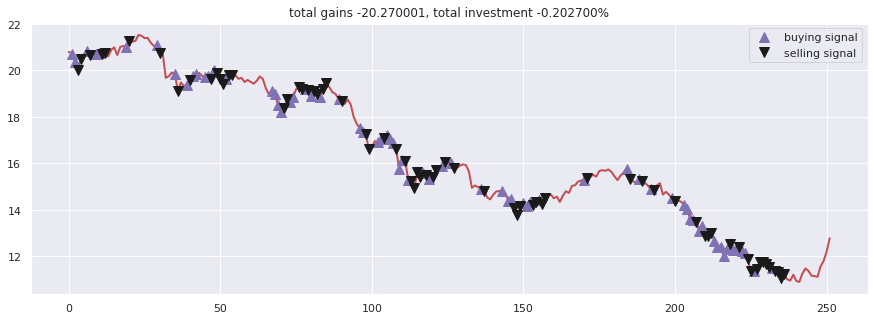

In [ ]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()